<a href="https://colab.research.google.com/github/Avani1994/NLP/blob/main/MPAARatingsMessagink.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! unzip wiki-news-300d-1M.vec.zip

unzip:  cannot find or open wiki-news-300d-1M.vec.zip, wiki-news-300d-1M.vec.zip.zip or wiki-news-300d-1M.vec.zip.ZIP.


In [ ]:
import io
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
import matplotlib.pyplot as plt
import keras
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    fin.close()
    return data
embedding = load_vectors('/content/drive/My Drive/wiki-news-300d-1M.vec')

In [ ]:
def gloveEmbedding(fname):
  fin = open(fname, encoding='utf8')
  data = {}
  for line in fin:
    l = line.split()
    data[l[0]] = np.asarray(l[1:], dtype='float32')
  fin.close()
  return data
embeddingGlove = gloveEmbedding('/content/drive/MyDrive/glove.6B.100d.txt')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
plots_df = pd.read_csv('/content/drive/My Drive/all_movie.csv')
plots_df.head(15)

,Cast 1,Cast 2,Cast 3,Cast 4,Cast 5,Cast 6,Description,Director 1,Director 2,Director 3,Genre,Rating,Release Date,Runtime,Studio,Title,Writer 1,Writer 2,Writer 3,Writer 4,Year
0,Brendan Fraser,John Hannah,Maria Bello,Michelle Yeoh,Jet Li,Russell Wong,The Fast and the Furious director Rob Cohen co...,Rob Cohen,Simon Duggan,Director Not Available,Action,PG-13,7/24/2008,112 minutes,Universal Pictures,The Mummy: Tomb of the Dragon Emperor,Alfred Gough,Miles Millar,Writer Not Available,Writer Not Available,2008
1,Brett Granstaff,Diahann Carroll,Lara Jean Chorostecki,Roddy Piper,T.J. McGibbon,James Preston Rogers,The journey of a professional wrestler who bec...,Warren P. Sonoda,Director Not Available,Director Not Available,Action,PG-13,1/8/2016,111 minutes,Freestyle Releasing,The Masked Saint,Scott Crowell,Brett Granstaff,Writer Not Available,Writer Not Available,2016
2,Leslie Nielsen,Nicollette Sheridan,Andy Griffith,Marcia Gay Harden,John Ales,Barry Bostwick,"Dead pan Leslie Nielsen stars as Dick Steele, ...",Rick Friedberg,Director Not Available,Director Not Available,Action,PG-13,5/24/1996,80 minutes,Hollywood Pictures,Spy Hard,Rick Friedberg,Dick Chudnow,Jason Friedberg,Aaron Seltzer,1996
3,Martina Gedeck,Moritz Bleibtreu,Johanna Wokalek,Bruno Ganz,Nadja Uhl,Jan Josef Liefers,Director Uli Edel teams with screenwriter Bern...,Uli Edel,Director Not Available,Director Not Available,Action,R,9/25/2008,149 minutes,Vitagraph Films,Der Baader Meinhof Komplex (The Baader Meinhof...,Uli Edel,Bernd Eichinger,Writer Not Available,Writer Not Available,2008
4,Martin Sheen,Marlon Brando,Robert Duvall,Frederic Forrest,Sam Bottoms,Laurence Fishburne,One of a cluster of late-1970s films about the...,Francis Ford Coppola,Director Not Available,Director Not Available,Action,R,1/1/1979,153 minutes,United Artists,Apocalypse Now,John Milius,Francis Ford Coppola,Michael Herr,Writer Not Available,1979
5,Johnny Depp,Gwyneth Paltrow,Ewan McGregor,Olivia Munn,Jeff Goldblum,Paul Bettany,"Juggling some angry Russians, the British Mi5,...",David Koepp,Director Not Available,Director Not Available,Action,R,1/23/2015,106 minutes,Liongate Films,Mortdecai,Eric Aronson,Writer Not Available,Writer Not Available,Writer Not Available,2015
6,Jeremy Renner,Anthony Mackie,Brian Geraghty,Guy Pearce,Ralph Fiennes,David Morse,Based on the personal wartime experiences of j...,Kathryn Bigelow,Director Not Available,Director Not Available,Action,R,6/26/2009,131 minutes,Summit Entertainment,The Hurt Locker,Mark Boal,Writer Not Available,Writer Not Available,Writer Not Available,2009
7,Jim Carter,Rasmus Hardiker,Alice Krige,Tim Pigott-Smith,Miriam Margolyes,Matthew Marsh,"THE LITTLE VAMPIRE, based on the characters fr...",Richard Claus,Karsten Kiilerich,Director Not Available,Action,NR,8/28/2018,82 minutes,Studio Not Available,The Little Vampire 3D,Angela Sommer-Bodenburg,Larry Wilson,Richard Claus,Writer Not Available,2017
8,Jack Nicholson,Warren Beatty,Stockard Channing,Florence Stanley,Richard B. Shull,Thomas Newman,Three's a crowd in Mike Nichols's period caper...,Mike Nichols,Director Not Available,Director Not Available,Action,PG,5/20/1975,88 minutes,Columbia Pictures,The Fortune,Carole Eastman,Adrien Joyce,Writer Not Available,Writer Not Available,1975
9,Robert Mitchum,Deborah Kerr,Cast Not Available,Cast Not Available,Cast Not Available,Cast Not Available,A two-person character study directed by John ...,John Huston,Director Not Available,Director Not Available,Action,NR,1/1/1957,108 minutes,Fox,Heaven Knows Mr. Allison,John Lee Mahin,John Huston,Writer Not Available,Writer Not Available,1957


In [ ]:
plots_df = plots_df[['Title','Description','Rating']]
plots_df['Rating'] = plots_df['Rating'].str.strip()
#plots_df['Rating'] = plots_df['Rating' != 'NR']
plots_df = plots_df.loc[(plots_df['Rating'] != 'NR')]
plots_df.Rating.unique()


array(['PG-13', 'R', 'PG', 'G', 'NC17'], dtype=object)

In [ ]:
plots_df.describe()

,Title,Description,Rating
count,21805,21804,21805
unique,10696,10893,5
top,Home,Rose Hathaway (Deutch) is a Dhampir: half huma...,R
freq,7,7,10884


In [ ]:
plots_df.isnull().sum()

Title          0
Description    1
Rating         0
dtype: int64

In [ ]:
plots_df = plots_df.loc[plots_df['Description'].notnull()]


In [ ]:
plots_df.groupby(['Rating']).size()

Rating
G         1605
NC17        91
PG        4172
PG-13     5052
R        10884
dtype: int64

In [ ]:
plots_df["Rating"].isnull().sum()

0

In [ ]:
plots_df.Description[0]

"The Fast and the Furious director Rob Cohen continues the tale set into motion by director Stephen Sommers with this globe-trotting adventure that finds explorer Rick O'Connell and son attempting to thwart a resurrected emperor's (Jet Li) plan to enslave the entire human race. It's been 2,000 years since China's merciless Emperor Han and his formidable army were entombed in terra cotta clay by a double-dealing sorceress (Michelle Yeoh), but now, after centuries in suspended animation, an ancient curse is about to be broken. Thanks to his childhood adventures alongside father Rick (Brendan Fraser) and mother Evelyn (Maria Bello), dashing young archeologist Alex O'Connell (Luke Ford) is more than familiar with the power of the supernatural. After he is tricked into awakening the dreaded emperor from his eternal slumber, however, the frightened young adventurer is forced to seek out the wisdom of his parents -- both of whom have had their fair share of experience battling the legions of 

In [ ]:
# Preprocess text to tokenize it further
def preprocessText(text):
  text = re.sub(r'\W+', ' ', text) # Remove special chars
  text = re.sub(r'\s+[a-zA-z0-9]\s+', ' ', text) # remove single letters/numbers
  text = re.sub(r'^[a-zA-z0-9]\s+', ' ', text) # remove single letters/numbers at start of the text
  text = re.sub(r'\s+', ' ', text) # remove multiple spaces
  text = text.lower() # convert lower case
  text = text.split(' ') # split for removing stop words
  text = [word for word in text if word not in stopwords]
  return ' '.join(text)

preprocessedText = []
for sent in plots_df.Description:
  #print(sent)
  preprocessedText.append(preprocessText(sent))

labelEncoder = LabelEncoder()
y = labelEncoder.fit_transform(plots_df['Rating'])

xTrain, xTest, yTrain, yText = train_test_split(preprocessedText, y, test_size = 0.2, random_state = 45)

yTrain = to_categorical(yTrain)
yText = to_categorical(yText)


In [ ]:
# Tokenize - 3 options Keras Tokenizer (allows to fit text, get vocab),
# spacy.io tokenizer (Check in this link for text to sequences - (https://stackoverflow.com/questions/53212374/how-to-get-token-ids-using-spacy-i-want-to-map-a-text-sentence-to-sequence-of-i),
# nltk tokenizer (based on regular expressions - grammar/punctuation/space/wordtokenizer ),

tok = Tokenizer()
tok.fit_on_texts(xTrain)
train = tok.texts_to_sequences(xTrain)
test = tok.texts_to_sequences(xTest)
vocabSize = len(tok.word_index) + 1
maxlen = 400
train = pad_sequences(train, maxlen = maxlen)
test = pad_sequences(test, maxlen = maxlen)


#Now create embedding matrix for model

embeddingMatrix = np.zeros((vocabSize, 100))

for word, i in tok.word_index.items():
  if(word in embeddingGlove):
    word_vec = embeddingGlove[word]
    embeddingMatrix[i] = word_vec





In [ ]:
# Build model
# Simple Model using biLSTMs first

model = Sequential()
model.add(Embedding(input_dim = vocabSize,  output_dim = 100, weights = [embeddingMatrix], trainable = False))
model.add(Bidirectional(LSTM(units = 128, dropout = 0.2, return_sequences=True, recurrent_dropout = 0.2), merge_mode='concat'))
model.add(Bidirectional(LSTM(units = 128, dropout = 0.2, recurrent_dropout = 0.2), merge_mode='concat'))
model.add(Dense(5, activation = 'softmax'))
opt = keras.optimizers.Adam()
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

print(xTrain[0])



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         4975600   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         234496    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 5,605,621
Trainable params: 630,021
Non-trainable params: 4,975,600
_________________________________________________________________
coraline jones girl 11 feisty curious adventurous beyond years parents relocated michigan oregon missing friends finding parents distracted work coraline tries find excitement new environment coraline seriously doubts new home provide a

In [ ]:
hist = model.fit(train, yTrain, batch_size = 128, epochs = 35, validation_split = 0.2, verbose = 1)




Epoch 1/35
110/110 [==============================] - 730s 7s/step - loss: 1.2012 - accuracy: 0.5127 - val_loss: 1.0996 - val_accuracy: 0.5085
Epoch 2/35
110/110 [==============================] - 718s 7s/step - loss: 1.0816 - accuracy: 0.5374 - val_loss: 1.3271 - val_accuracy: 0.4018
Epoch 3/35
110/110 [==============================] - 719s 7s/step - loss: 1.0581 - accuracy: 0.5348 - val_loss: 0.9935 - val_accuracy: 0.5744
Epoch 4/35
110/110 [==============================] - 717s 7s/step - loss: 0.9614 - accuracy: 0.5987 - val_loss: 0.9806 - val_accuracy: 0.5747
Epoch 5/35
110/110 [==============================] - 713s 6s/step - loss: 0.9631 - accuracy: 0.6022 - val_loss: 0.9978 - val_accuracy: 0.5758
Epoch 6/35
110/110 [==============================] - 714s 6s/step - loss: 0.9032 - accuracy: 0.6247 - val_loss: 0.9389 - val_accuracy: 0.5979
Epoch 7/35
110/110 [==============================] - 712s 6s/step - loss: 0.8492 - accuracy: 0.6473 - val_loss: 0.9452 - val_accuracy: 0.6088

In [ ]:
loss, acc = model.evaluate(test, yText, verbose = 1)
print('loss:', loss)
print('accuracy:', acc)

137/137 [==============================] - 43s 315ms/step - loss: 0.8386 - accuracy: 0.8152
loss: 0.8385891318321228
accuracy: 0.8151800036430359


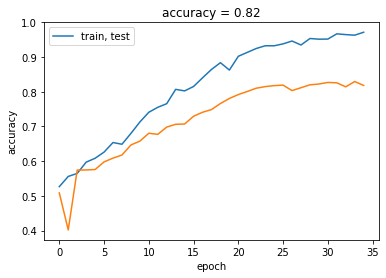

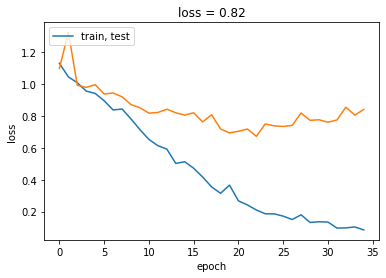

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('accuracy = {:.2f}'.format(acc))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train, test'], loc ='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('loss = {:.2f}'.format(acc))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train, test'], loc ='upper left')
plt.show()

In [ ]:
#Save model
model.save('movie_rating_classifier.h5')

#Save tokenizer
pickle.dump(tok, open('tokenizer.pkl', 'wb'))



In [ ]:
# dictionary of key-value mappings for MPAA ratings
mpaa_ratings = { 0:'G', 1:'NC-17', 2:'PG', 3:'PG-13', 4:'R' }

story = ""
#story = xTrain[0]
print(xTrain[0])
print(yTrain[0])
saved_tok = pickle.load(open('tokenizer.pkl', 'rb'))
story = saved_tok.texts_to_sequences(story)
flat_list = []
for sublist in story:
    for item in sublist:
        flat_list.append(item)
story = pad_sequences([flat_list], maxlen=maxlen)

prediction = model.predict_classes(story)
print(prediction)
print('prediction:', mpaa_ratings[prediction[0]])



coraline jones girl 11 feisty curious adventurous beyond years parents relocated michigan oregon missing friends finding parents distracted work coraline tries find excitement new environment coraline seriously doubts new home provide anything truly intriguing uncovers secret door house walking door venturing eerie passageway discovers alternate version life existence 
[0. 0. 1. 0. 0.]
[2]
prediction: PG


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
